In [76]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel,AutoModelForMaskedLM, RobertaModel, RobertaTokenizer
import torch
import torch.nn.functional as F
from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function
import gc
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Данные

In [78]:
from torch.utils.data import Dataset, DataLoader 
import numpy as np 
import math 

class RESDDataset(): 
    def __init__(self, part='train'): 
        if part == 'train':
            df = pd.read_csv("train.csv")
        elif part == 'test':
            df = pd.read_csv("test.csv")
        else:
            raise ValueError('Unknown part of RESDDataset (train / test)')
        self.x = list(df['text'].values)
        transform_dict = {'anger' : 0, 'disgust' : 1, 'fear' : 2, 'sadness' : 3, 'neutral' : 4, 'happiness' : 5, 'enthusiasm' : 6}
        self.y = torch.tensor(df['emotion'].apply(lambda x : transform_dict[x])).to(device)
        self.n_samples = df.shape[0]  

    def __getitem__(self, index): 
        return self.x[index], self.y[index] 
        
    def __len__(self): 
        return self.n_samples 

### Feature Extractor

In [5]:
class Embedding():
    def __init__(self, model_name='jina', pooling=None):
        self.model_name = model_name
        self.pooling = pooling
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if model_name == 'jina':
            self.tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v3", code_revision='da863dd04a4e5dce6814c6625adfba87b83838aa', trust_remote_code=True)
            self.model = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", code_revision='da863dd04a4e5dce6814c6625adfba87b83838aa', trust_remote_code=True).to(self.device)
        elif model_name == 'xlm-roberta-base':
            self.tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
            self.model = AutoModel.from_pretrained('xlm-roberta-base').to(self.device)
        elif model_name == 'canine-c':
            self.tokenizer = AutoTokenizer.from_pretrained('google/canine-c')
            self.model = AutoModel.from_pretrained('google/canine-c').to(self.device)
        else:
            raise ValueError('Unknown name of Embedding')
    def _mean_pooling(self, X):
        def mean_pooling(model_output, attention_mask):
            token_embeddings = model_output[0]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        encoded_input = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt').to(self.device)
        with torch.no_grad():
            model_output = self.model(**encoded_input)
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        return sentence_embeddings.unsqueeze(1)
    
    def get_embeddings(self, X):
        if self.pooling is None:
            if self.model_name == 'canine-c_emb':
                max_len = 300
            else:
                max_len = 88
            encoded_input = self.tokenizer(X, padding=True, truncation=True, return_tensors='pt').to(self.device)
            with torch.no_grad():
                features = self.model(**encoded_input)[0].detach().cpu().float().numpy()
            res = np.pad(features[:, :max_len, :], ((0, 0), (0, max(0, max_len - features.shape[1])), (0, 0)), "constant")
            return torch.tensor(res)
        elif self.pooling == 'mean':
            return self._mean_pooling(X)
        else:
            raise ValueError('Unknown type of pooling')

# Обучение

In [10]:
from dataclasses import dataclass
from typing import ClassVar
from typing import List, Dict, Any, Tuple, Optional
@dataclass
class ModelTrainer:
    model: 'typing.Any'
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    device: torch.device
    epochs: int
    round_loss: int
    round_acc: int

    optimizer: torch.optim
    loss_fn: 'typing.Any'
    
    patience: int = 5 # Ранняя остановка обучения

    class_names: ClassVar[Optional[List[str]]] = None # Список имен классов

    def __post_init__(self):
        
        # История обучения и тестирования
        self.__history = pd.DataFrame({
            "train_acc": [], # Точность на тренировочной выборке
            "test_acc": [], # Точность на тестовой выборке
            "train_loss": [], # Loss на тренировочной выборке
            "test_loss": [] # Loss на тестовой выборке
        })

        # Количество шагов в одной эпохе
        self.__train_steps = len(self.train_dataloader)
        self.__test_steps = len(self.test_dataloader)

        self.__best_test_accuracy = 0
        self.__no_improvement_count = 0
        
        self.loss_fn = self.loss_fn

    @property
    def history(self) -> pd.DataFrame:
        """Получение DataFrame историей обучения и тестирования

        Returns:
            pd.DataFrame: **DataFrame** c историей обучения и тестирования
        """

        return self.__history

    @classmethod
    def get_model_logits(cls, logits: torch.Tensor) -> torch.Tensor:
        """Получение логитов модели в зависимости от функции потерь

        Args:
            logits (torch.Tensor): Входные логиты

        Returns:
            torch.Tensor: Обработанные логиты
        """

        if isinstance(cls.loss_fn, nn.NLLLoss):
            log_softmax = nn.LogSoftmax(dim = 1)
            return log_softmax(logits)
        elif isinstance(cls.loss_fn, nn.CrossEntropyLoss):
            return logits

    def _is_best_model(self, test_accuracy: float) -> bool:
        """Проверка, является ли текущая модель лучшей на основе точности тестирования

        Args:
            test_accuracy (float): Текущая точность тестирования

        Returns:
            bool: True, если текущая модель лучшая, иначе False
        """

        try:
            max_test_acc = max(self.__history["test_acc"])
        except ValueError:
            max_test_acc = 0
        return test_accuracy > max_test_acc

    def _save_model(self, epoch: int, path_to_model: str, test_accuracy: float, loss: torch.Tensor) -> None:
        """Сохранение модели

        Args:
            epoch (int): Текущая эпоха
            path_to_model (str): Путь для сохранения модели
            test_accuracy (float): Точность на тестовой выборке
            loss (torch.Tensor): Значение потерь
        """
        
        os.makedirs(path_to_model, exist_ok = True)

        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "test_loss": loss,
        }, os.path.join(path_to_model, f"{self.model.__class__.__name__}_{self.model.model_name}_{epoch}_{test_accuracy}_checkpoint.pth"))
    
    # Процесс обучения
    def train(self, path_to_model: str) -> None:
        """Процесс обучения

        Args:
            path_to_model (str): Путь для сохранения моделей

        Returns:
            None
        """
        
        losses_train_list = []
        losses_test_list = []
        accuracy_train_list = []
        accuracy_test_list = []

        for epoch in range(1, self.epochs + 1):
            with torch.no_grad():
                torch.cuda.empty_cache()
            self.model.train() # Установка модели в режим обучения
            # Сумма Loss
            total_train_loss = 0
            total_test_loss = 0
            # Сумма точности
            train_accuracy = 0
            test_accuracy = 0

            # Проход по всем тренировочным пакетам
            with tqdm(total = self.__train_steps, desc = f"Эпоха {epoch}", unit = "batch") as pbar_train:
                for batch, (batch_X, targets) in enumerate(self.train_dataloader, 1):
                    logits = self.model(batch_X)
                    loss = self.loss_fn(logits, targets) # Ошибка предсказаний

                    # Обратное распространение для обновления весов
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
        
                    total_train_loss += loss.item() # Потеря
                    # Количество правильных предсказаний
                    train_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                    pbar_train.update(1)
                    with torch.no_grad():
                        torch.cuda.empty_cache()

                # Средняя потеря
                avg_train_loss = round(total_train_loss / batch, self.round_loss)
                losses_train_list.append(avg_train_loss)
        
                # Точность
                train_accuracy = round(train_accuracy / len(self.train_dataloader.dataset) * 100, self.round_acc)
                accuracy_train_list.append(train_accuracy)
        
                pbar_train.set_postfix({
                    "Точность": train_accuracy,
                    "Средняя потеря": avg_train_loss
                })
            
            
            # Установка модели в режим предсказаний
            self.model.eval()
        
            # Предсказания на тестовой выборке
            with torch.no_grad():
                with tqdm(total = self.__test_steps, desc = f"Тестирование {epoch}", unit = "batch") as pbar_test:
                    # Проход по всем тестовым пакетам
                    for batch, (batch_X, targets) in enumerate(self.test_dataloader, 1):
                        logits = self.model(batch_X)
                        loss = self.loss_fn(logits, targets) # Ошибка предсказаний
                        
                        total_test_loss += loss.item() # Потеря
                        # Количество правильных предсказаний
                        test_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                        pbar_test.update(1)
                        with torch.no_grad():
                            torch.cuda.empty_cache()

                    # Средняя потеря
                    avg_test_loss = round(total_test_loss / batch, self.round_loss)
                    losses_test_list.append(avg_test_loss)
        
                    # Точность
                    test_accuracy = round(test_accuracy / len(self.test_dataloader.dataset) * 100, self.round_acc)
                    accuracy_test_list.append(test_accuracy)
                    
                    pbar_test.set_postfix({
                        "Точность": test_accuracy,
                        "Средняя потеря": avg_test_loss
                    })
            
            if self._is_best_model(test_accuracy):
                self._save_model(epoch, path_to_model, test_accuracy, avg_test_loss)
                self.__best_test_accuracy = test_accuracy
                self.__no_improvement_count = 0
            else:
                self.__no_improvement_count += 1

            # Добавлениие данных в историю обучения
            new_row = pd.Series([train_accuracy, test_accuracy, avg_train_loss, avg_test_loss], index = self.__history.columns)
            self.__history = pd.concat([self.__history, new_row.to_frame().T], ignore_index = True)

            if self.__no_improvement_count >= self.patience:
                print(f"Ранняя остановка на эпохе {epoch} из-за отсутствия улучшения точности на тестовой выборке")
                break
        # Визуализация графиков потерь и точности
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(losses_train_list, label = 'Потери на тренировочной выборке')
        plt.plot(losses_test_list, label = 'Потери на тестовой выборке')
        plt.title('Потери во время обучения')
        plt.xlabel('Эпоха')
        plt.ylabel('Потери')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(accuracy_train_list, label = 'Точность на тренировочной выборке')
        plt.plot(accuracy_test_list, label = 'Точность на тестовой выборке')
        plt.title('Точность во время обучения')
        plt.xlabel('Эпоха')
        plt.ylabel('Точность')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Получение хэш-значения
    def __hash__(self):
        return id(self)

### Метрики

In [11]:
def evaluate_metrics(model, test_dataloader):
    model.eval()
    y_test = []
    y_predict = []
    with torch.no_grad():
        for batch, (batch_X, targets) in enumerate(test_dataloader, 1):
            y_test.extend(list(map(int, targets)))
            output = model(batch_X)
            _, predictions = torch.max(output, dim=1)
            y_predict.extend(list(map(int, predictions)))
        # Unweighted Average Recall (UAR)
        uar = recall_score(y_test, y_predict, average='macro')
        # Weighted Average Recall (WAR)
        war = recall_score(y_test, y_predict, average='weighted')
        # Macro F1-score (MF1)
        mf1 = f1_score(y_test, y_predict, average='macro')
        # Weighted F1-score (WF1)
        wf1 = f1_score(y_test, y_predict, average='weighted')
    return {'uar': uar, 'war': war, 'mf1': mf1, 'wf1': wf1}

In [12]:
EPOCHS = 20 # Количество эпох
BATCH_SIZE = 32 # Размер выборки (пакета)
LEARNING_RATE = 1e-4 # Скорость обучения
ROUND_ACC = 2 # Знаков Accuracy после запятой
ROUND_LOSS = 7 # Знаков Loss после запятой
# Проверка наличия GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_DIR = os.path.join(".")
PATH_TO_MODEL = os.path.join(ROOT_DIR, "models_RESD")

In [13]:
train_dataloader = DataLoader(dataset=RESDDataset('train'), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=RESDDataset('test'), batch_size=BATCH_SIZE, shuffle=False)

### Transformer

In [7]:
class TransformerModelWithAttention(nn.Module):
    def __init__(self, num_classes, model_name='jina', pooling=None, num_heads = 8, num_layers = 10, hidden_dim = 1024, dropout = 0.1):
        super(TransformerModelWithAttention, self).__init__()
        embed = Embedding(model_name, pooling)
        self.embedding = embed.get_embeddings
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.positional_encoding = nn.Parameter(torch.zeros(1, 500, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model = hidden_dim, nhead = num_heads, dim_feedforward = hidden_dim, dropout = dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.tensor(self.embedding(x)).to(self.device)
        batch_size, seq_len, _ = x.size()
        x = x + self.positional_encoding[:, :seq_len, :]
        encoder_output = self.transformer_encoder(x).to(self.device)      
        x = encoder_output.mean(dim = 1) # Глобальное усреднение для классификации
        return self.fc_out(x)

#### Transformer + jina with mean pooling

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 8 из-за отсутствия улучшения точности на тестовой выборке


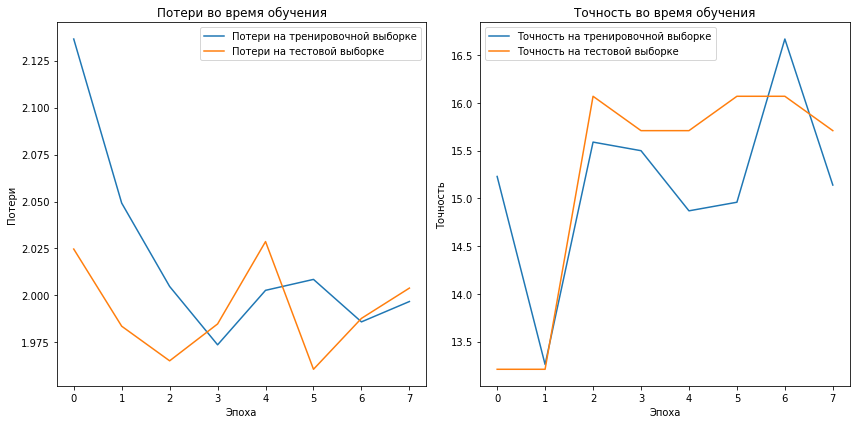

In [65]:
model = TransformerModelWithAttention(model_name='jina', pooling='mean', num_classes = 7).to(device)
optimizer = optim.AdamW(params = model.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn)
trainer.train(PATH_TO_MODEL)

In [66]:
model_transformer_best = TransformerModelWithAttention(model_name='jina', pooling='mean', num_classes = 7).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "TransformerModelWithAttention_jina_3_16.07_checkpoint.pth"))
model_transformer_best.load_state_dict(checkpoint['model_state_dict'])

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

<All keys matched successfully>

In [67]:
evaluate_metrics(model_transformer_best, test_dataloader)

{'uar': 0.14285714285714285,
 'war': 0.16071428571428573,
 'mf1': 0.039560439560439566,
 'wf1': 0.04450549450549451}

#### Transformer + jina

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке


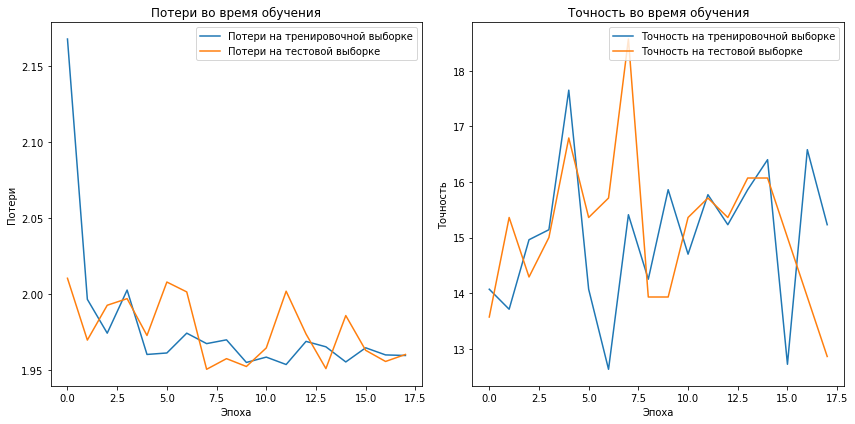

In [71]:
model = TransformerModelWithAttention(num_classes = 7, model_name='jina').to(device)
optimizer = optim.AdamW(params = model.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [72]:
model_transformer_best = TransformerModelWithAttention(num_classes = 7, model_name='jina').to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "TransformerModelWithAttention_jina_8_18.57_checkpoint.pth"))
model_transformer_best.load_state_dict(checkpoint['model_state_dict'])

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

<All keys matched successfully>

In [73]:
evaluate_metrics(model_transformer_best, test_dataloader)

{'uar': 0.1688311688311688,
 'war': 0.18571428571428572,
 'mf1': 0.08249194414607948,
 'wf1': 0.09074113856068743}

#### Transformer + xlm-roberta-base with mean pooling

Тестирование 12: 100%|██████████| 9/9 [00:05<00:00,  1.58batch/s, Точность=15.7, Средняя потеря=1.95]


Ранняя остановка на эпохе 12 из-за отсутствия улучшения точности на тестовой выборке


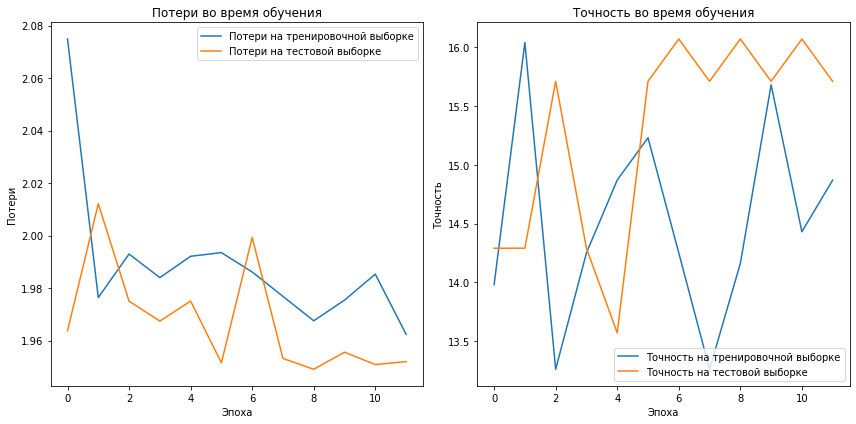

In [15]:
model_transformer = TransformerModelWithAttention(num_classes = 7, model_name='xlm-roberta-base', pooling='mean', hidden_dim=768, num_heads=8).to(device)
optimizer = optim.AdamW(params = model_transformer.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_transformer, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn)
trainer.train(PATH_TO_MODEL)

In [14]:
model_transformer_best = TransformerModelWithAttention(num_classes = 7, model_name='xlm-roberta-base', pooling='mean', hidden_dim=768, num_heads=8).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "TransformerModelWithAttention_xlm-roberta-base_7_16.07_checkpoint.pth"))
model_transformer_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
evaluate_metrics(model_transformer_best, test_dataloader)

{'uar': 0.14285714285714285,
 'war': 0.16071428571428573,
 'mf1': 0.039560439560439566,
 'wf1': 0.04450549450549451,
 'accuracy': 0.16071428571428573}

#### Transformer + xlm-roberta-base

Тестирование 24: 100%|██████████| 9/9 [00:07<00:00,  1.13batch/s, Точность=15.7, Средняя потеря=1.95]


Ранняя остановка на эпохе 24 из-за отсутствия улучшения точности на тестовой выборке


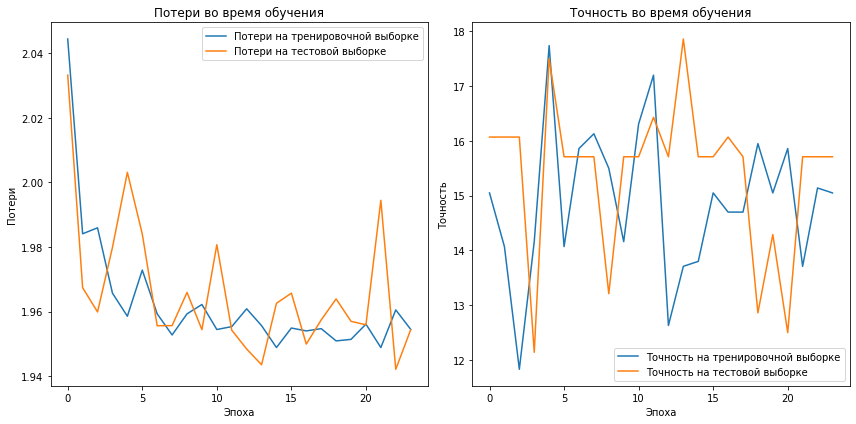

In [12]:
model_transformer = TransformerModelWithAttention(num_classes = 7, model_name='xlm-roberta-base', pooling=None, hidden_dim=768, num_heads=8).to(device)
optimizer = optim.AdamW(params = model_transformer.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_transformer, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [13]:
model_transformer_best = TransformerModelWithAttention(num_classes = 7, model_name='xlm-roberta-base', pooling=None, hidden_dim=768, num_heads=8).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "TransformerModelWithAttention_xlm-roberta-base_emb_14_17.86_checkpoint.pth"))
model_transformer_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
evaluate_metrics(model_transformer_best, test_dataloader)

{'uar': 0.16233766233766236,
 'war': 0.17857142857142858,
 'mf1': 0.07683494450411743,
 'wf1': 0.08451843895452918,
 'accuracy': 0.17857142857142858}

#### Transformer + canine-c with mean pooling

Тестирование 11: 100%|██████████| 9/9 [00:00<00:00, 11.89batch/s, Точность=16.1, Средняя потеря=1.95]


Ранняя остановка на эпохе 11 из-за отсутствия улучшения точности на тестовой выборке


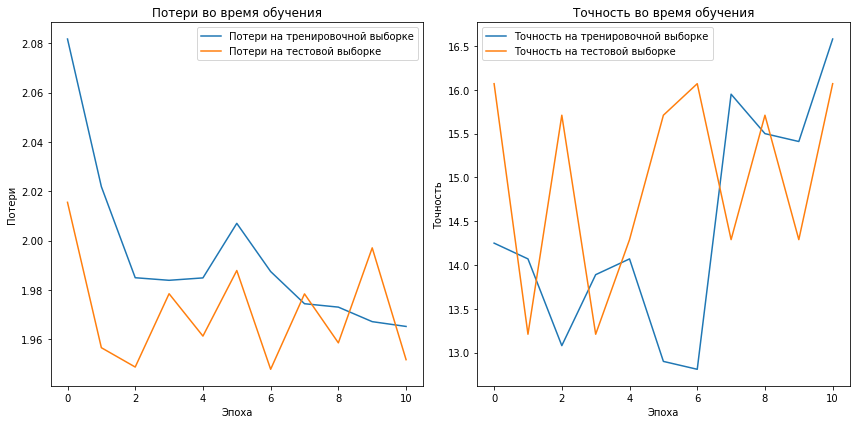

In [15]:
model_transformer = TransformerModelWithAttention(num_classes = 7, model_name='canine-c', pooling='mean', hidden_dim=768, num_heads=8).to(device)
optimizer = optim.AdamW(params = model_transformer.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_transformer, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

Тестирование 16: 100%|██████████| 9/9 [00:00<00:00, 14.32batch/s, Точность=15.7, Средняя потеря=1.97]


Ранняя остановка на эпохе 16 из-за отсутствия улучшения точности на тестовой выборке


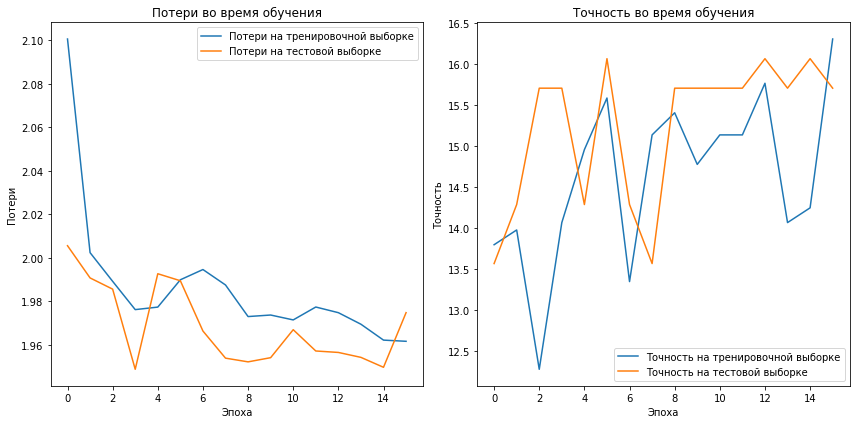

In [62]:
model_transformer = TransformerModelWithAttention(num_classes = 7, model_name='canine-c', pooling='mean', hidden_dim=768, num_heads=8).to(device)
optimizer = optim.AdamW(params = model_transformer.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_transformer, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [63]:
model_transformer_best = TransformerModelWithAttention(num_classes = 7, model_name='canine-c', pooling='mean', hidden_dim=768, num_heads=8).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "TransformerModelWithAttention_canine-c_6_16.07_checkpoint.pth"))
model_transformer_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [64]:
evaluate_metrics(model_transformer_best, test_dataloader)

{'uar': 0.14285714285714285,
 'war': 0.16071428571428573,
 'mf1': 0.039560439560439566,
 'wf1': 0.04450549450549451}

#### Transformer + canine-c

Тестирование 12: 100%|██████████| 9/9 [00:08<00:00,  1.01batch/s, Точность=12.9, Средняя потеря=1.96]


Ранняя остановка на эпохе 12 из-за отсутствия улучшения точности на тестовой выборке


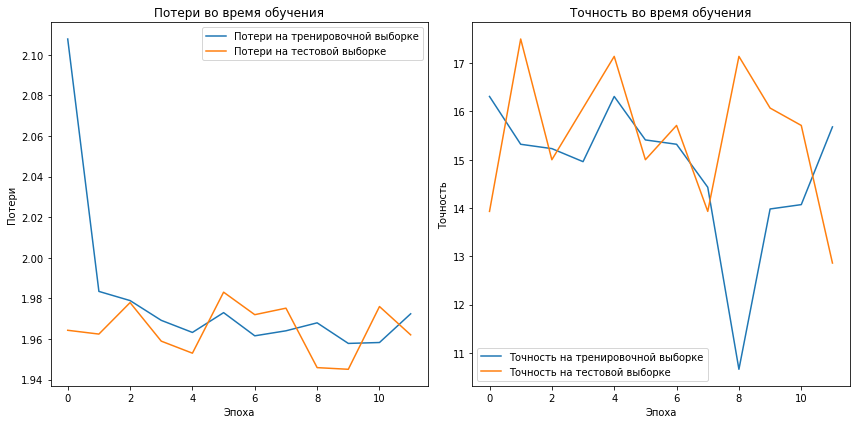

In [16]:
model_transformer = TransformerModelWithAttention(num_classes = 7, model_name='canine-c', pooling=None, hidden_dim=768, num_heads=8).to(device)
optimizer = optim.AdamW(params = model_transformer.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_transformer, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [18]:
model_transformer_best = TransformerModelWithAttention(num_classes = 7, model_name='canine-c', pooling=None, hidden_dim=768, num_heads=8).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "TransformerModelWithAttention_canine-c_emb_2_17.5_checkpoint.pth"))
model_transformer_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
evaluate_metrics(model_transformer_best, test_dataloader)

{'uar': 0.1623376623376623,
 'war': 0.175,
 'mf1': 0.07032967032967033,
 'wf1': 0.07461538461538461,
 'accuracy': 0.175}

### Mamba

In [18]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp: Tensor) -> Tuple[Tensor, Tensor]:
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim = 2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s")
        grad_out = grad_out.flip(2)
        PScan._forward(A, grad_out)
        grad_out = grad_out.flip(2)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return rearrange(Q, "b d l s -> b l d s"), rearrange(grad_out, "b d l s -> b l d s")

    @staticmethod
    def _forward(A: Tensor, X: Tensor) -> None:
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps - 1, -1, -1):
            Av, Xv = A[:, :, 2**k - 1 : l : 2**k], X[:, :, 2**k - 1 : l : 2**k]
            T = 2 * (Xv.size(2) // 2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T // 2, 2, -1), Xv[:, :, :T].reshape(b, d, T // 2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan: Callable[[Tensor, Tensor], Tensor] = PScan.apply

class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-8) -> None:
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x: Tensor) -> Tensor:        
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim = True) + self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super(MambaBlock, self).__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x = x.to(device)
        x = self.in_proj(x)
        B, C = self.s_B(x), self.s_C(x)
        res = self.out_proj(x + B + C)
        return res

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model, num_classes, model_name='jina', pooling=None):
        super(Mamba, self).__init__()
        embed = Embedding(model_name, pooling)
        self.embedding = embed.get_embeddings
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_input, num_classes)
        self.model_name = model_name

    def forward(self, seq):
        seq = torch.tensor(self.embedding(seq)).to(device)
        for mamba in self.layers:
            seq = mamba(seq)
        return self.fc_out(seq.mean(dim = 1))
    def predict(self, x):
        transform_idx_to_labels = ['anger', 'disgust', 'fear', 'sadness', 'neutral', 'happiness', 'enthusiasm']
        with torch.no_grad():
            output = self.forward(x)
            _, predictions = torch.max(output, dim=1)
            result = [transform_idx_to_labels[i] for i in (map(int, predictions))]
        return result

#### Mamba + jina with mean pooling

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 14 из-за отсутствия улучшения точности на тестовой выборке


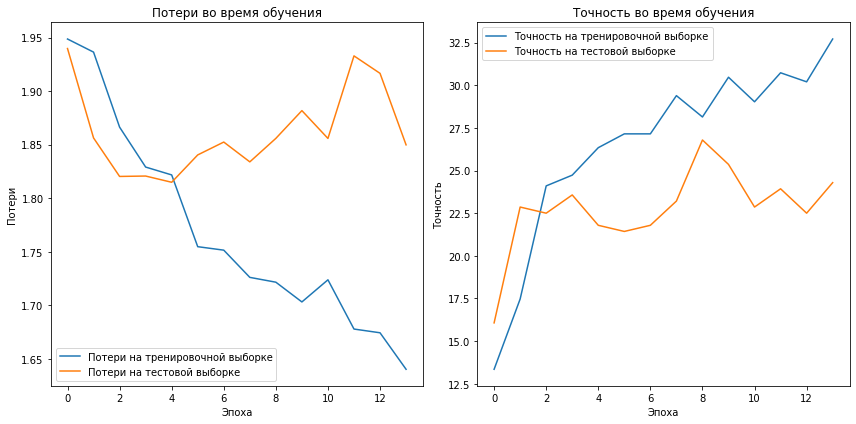

In [13]:
model_mamba = Mamba(num_layers = 6, d_input = 1024, d_model = 256, num_classes=7, model_name='jina', pooling='mean').to(device)
optimizer = optim.AdamW(params = model_mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_mamba, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn)
trainer.train(PATH_TO_MODEL)

In [15]:
model_mamba_best = Mamba(num_layers = 6, d_input = 1024, d_model = 256, num_classes=7, model_name='jina', pooling='mean').to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "Mamba_jina_9_26.79_checkpoint.pth"))
model_mamba_best.load_state_dict(checkpoint['model_state_dict'])

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

<All keys matched successfully>

In [16]:
evaluate_metrics(model_mamba_best, test_dataloader)

{'uar': 0.24552962052962052,
 'war': 0.26785714285714285,
 'mf1': 0.19263157001240241,
 'wf1': 0.2077220033450818,
 'accuracy': 0.26785714285714285}

#### Mamba + xlm-roberta-base with mean pooling

Тестирование 11: 100%|██████████| 9/9 [00:26<00:00,  2.99s/batch, Точность=16.1, Средняя потеря=1.94]


Ранняя остановка на эпохе 11 из-за отсутствия улучшения точности на тестовой выборке


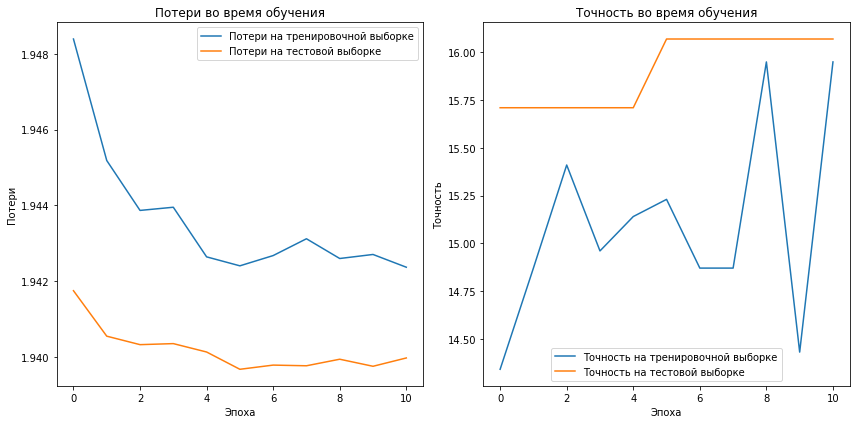

In [15]:
mamba = Mamba(model_name='xlm-roberta-base', pooling='mean', num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
optimizer = optim.AdamW(params = mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(mamba, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn)
trainer.train(PATH_TO_MODEL)

In [24]:
model_mamba_best = Mamba(model_name='xlm-roberta-base', pooling='mean', num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "Mamba_xlm-roberta-base_1_16.07_checkpoint.pth"))
model_mamba_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
evaluate_metrics(mamba, test_dataloader)

{'uar': 0.14285714285714285,
 'war': 0.16071428571428573,
 'mf1': 0.039560439560439566,
 'wf1': 0.04450549450549451}

#### Mamba + jina

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 19 из-за отсутствия улучшения точности на тестовой выборке


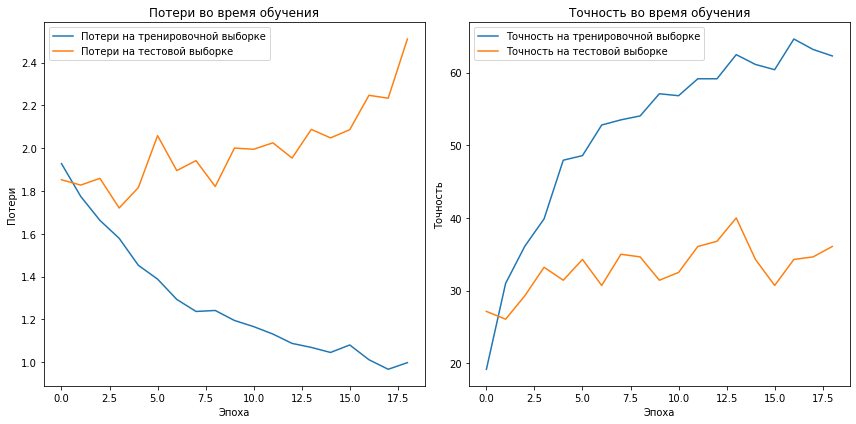

In [142]:
model_mamba = Mamba(model_name='jina', pooling=None, num_layers = 6, d_input = 1024, d_model = 256, num_classes=7).to(device)
optimizer = optim.AdamW(params = model_mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(model_mamba, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn)
trainer.train(PATH_TO_MODEL)

In [22]:
model_mamba_best = Mamba(model_name='jina', pooling=None, num_layers = 6, d_input = 1024, d_model = 256, num_classes=7).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "Mamba_jina_emb_14_40.0_checkpoint.pth"))
model_mamba_best.load_state_dict(checkpoint['model_state_dict'])

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

<All keys matched successfully>

In [23]:
evaluate_metrics(model_mamba_best, test_dataloader)

{'uar': 0.39391791826002354,
 'war': 0.4,
 'mf1': 0.39486657962848437,
 'wf1': 0.39949080372889895}

#### Mamba + xlm-roberta-base

Тестирование 24: 100%|██████████| 9/9 [00:04<00:00,  1.91batch/s, Точность=22.9, Средняя потеря=1.91]


Ранняя остановка на эпохе 24 из-за отсутствия улучшения точности на тестовой выборке


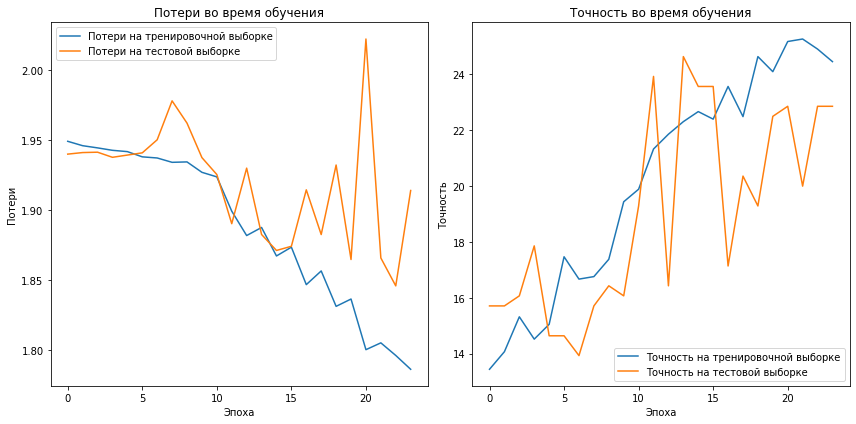

In [12]:
mamba = Mamba(model_name='xlm-roberta-base', pooling=None, num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
optimizer = optim.AdamW(params = mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(mamba, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [13]:
model_mamba_best = Mamba(model_name='xlm-roberta-base', pooling=None, num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "Mamba_xlm-roberta-base_emb_14_24.64_checkpoint.pth"))
model_mamba_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
evaluate_metrics(model_mamba_best, test_dataloader)

{'uar': 0.2253056884635832,
 'war': 0.24642857142857144,
 'mf1': 0.15435643687939335,
 'wf1': 0.1656900287729732,
 'accuracy': 0.24642857142857144}

#### Mamba + canine-c with mean pooling

Тестирование 22: 100%|██████████| 9/9 [00:00<00:00, 11.49batch/s, Точность=19.6, Средняя потеря=2.03]


Ранняя остановка на эпохе 22 из-за отсутствия улучшения точности на тестовой выборке


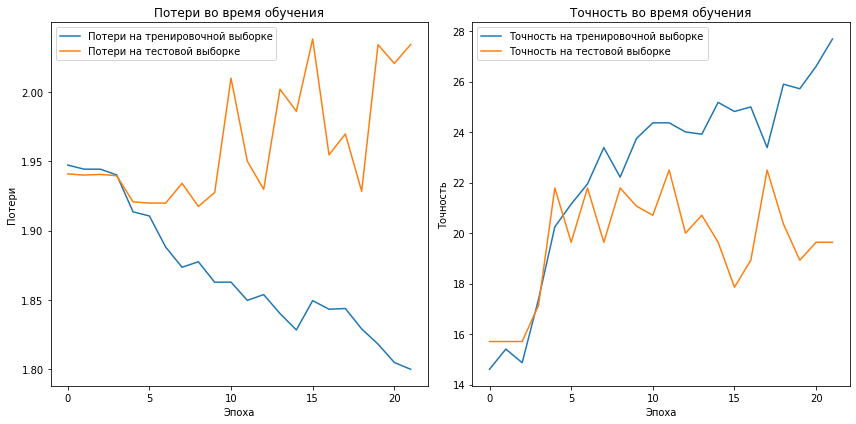

In [26]:
mamba = Mamba(model_name='canine-c', pooling='mean', num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
optimizer = optim.AdamW(params = mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(mamba, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [31]:
model_mamba_best = Mamba(model_name='canine-c', pooling='mean', num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "Mamba_canine-c_12_22.5_checkpoint.pth"))
model_mamba_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
evaluate_metrics(model_mamba_best, test_dataloader)

{'uar': 0.20202020202020204,
 'war': 0.225,
 'mf1': 0.12115834984687444,
 'wf1': 0.13452418483156187}

#### Mamba + canine-c

Тестирование 18: 100%|██████████| 9/9 [00:05<00:00,  1.67batch/s, Точность=20.4, Средняя потеря=2.21]


Ранняя остановка на эпохе 18 из-за отсутствия улучшения точности на тестовой выборке


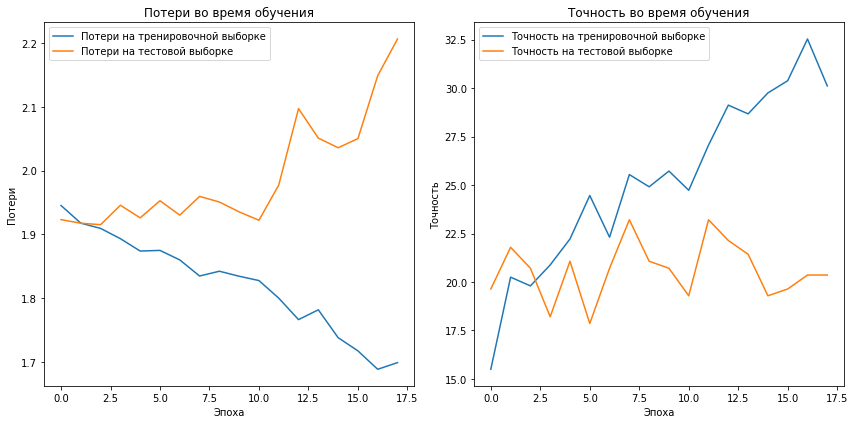

In [15]:
mamba = Mamba(model_name='canine-c', pooling=None, num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
optimizer = optim.AdamW(params = mamba.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(mamba, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [33]:
model_mamba_best = Mamba(model_name='canine-c', pooling=None, num_layers = 6, d_input = 768, d_model = 256, num_classes=7).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "Mamba_canine-c_emb_8_23.21_checkpoint.pth"))
model_mamba_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [34]:
evaluate_metrics(model_mamba_best, test_dataloader)

{'uar': 0.22442659679501784,
 'war': 0.2392857142857143,
 'mf1': 0.17037981614406097,
 'wf1': 0.17986244988053854}

### LSTM

In [37]:
class LSTMClassifier(nn.Module):
    def __init__(self, num_classes, model_name='jina', pooling=None, input_size = 1024, hidden_size = 32, num_layers = 2):
        super(LSTMClassifier, self).__init__()
        embed = Embedding(model_name, pooling)
        self.embedding = embed.get_embeddings
        self.model_name = model_name
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = torch.tensor(self.embedding(x)).to(device)
        h0, c0 = torch.zeros(self.num_layers, len(x), self.hidden_size).to(device), torch.zeros(self.num_layers, len(x), self.hidden_size).to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1])
        return out

#### LSTM + jina with mean pooling

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 22 из-за отсутствия улучшения точности на тестовой выборке


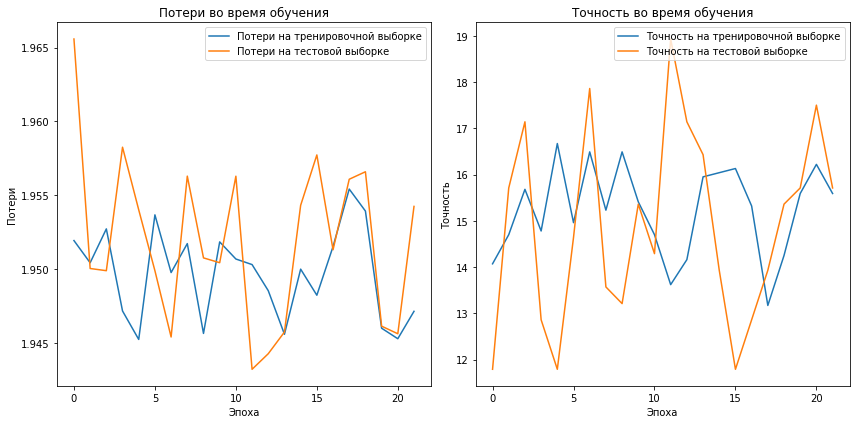

In [24]:
lstm = LSTMClassifier(num_classes = 7, model_name='jina', pooling='mean').to(device)
optimizer = optim.AdamW(params = lstm.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(lstm, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [34]:
model_lstm_best = LSTMClassifier(num_classes = 7, model_name='jina', pooling='mean').to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LSTMClassifier_jina_12_18.93_checkpoint.pth"))
model_lstm_best.load_state_dict(checkpoint['model_state_dict'])

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

<All keys matched successfully>

In [36]:
evaluate_metrics(model_lstm_best, test_dataloader)

{'uar': 0.17729936019409703,
 'war': 0.18928571428571428,
 'mf1': 0.13995055322622701,
 'wf1': 0.14825675852559023,
 'accuracy': 0.18928571428571428}

#### LSTM + jina

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

Ранняя остановка на эпохе 48 из-за отсутствия улучшения точности на тестовой выборке


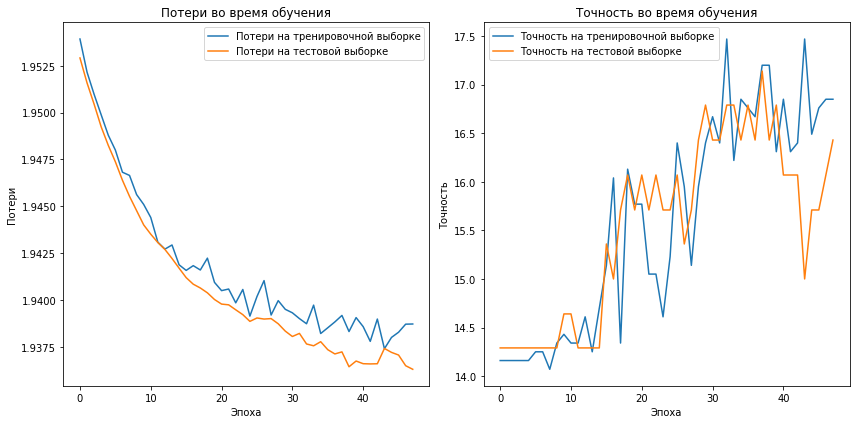

In [82]:
lstm = LSTMClassifier(num_classes = 7, model_name='jina', pooling=None).to(device)
optimizer = optim.AdamW(params = lstm.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(lstm, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [83]:
model_lstm_best = LSTMClassifier(num_classes = 7, model_name='jina', pooling=None).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LSTMClassifier_jina_38_17.14_checkpoint.pth"))
model_lstm_best.load_state_dict(checkpoint['model_state_dict'])

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

<All keys matched successfully>

In [84]:
evaluate_metrics(model_lstm_best, test_dataloader)

{'uar': 0.15303030303030302,
 'war': 0.17142857142857143,
 'mf1': 0.07817525581613567,
 'wf1': 0.08698413879480059}

#### LSTM + xlm-roberta-base with mean pooling

Тестирование 17: 100%|██████████| 9/9 [00:00<00:00, 23.56batch/s, Точность=16.1, Средняя потеря=1.94]


Ранняя остановка на эпохе 17 из-за отсутствия улучшения точности на тестовой выборке


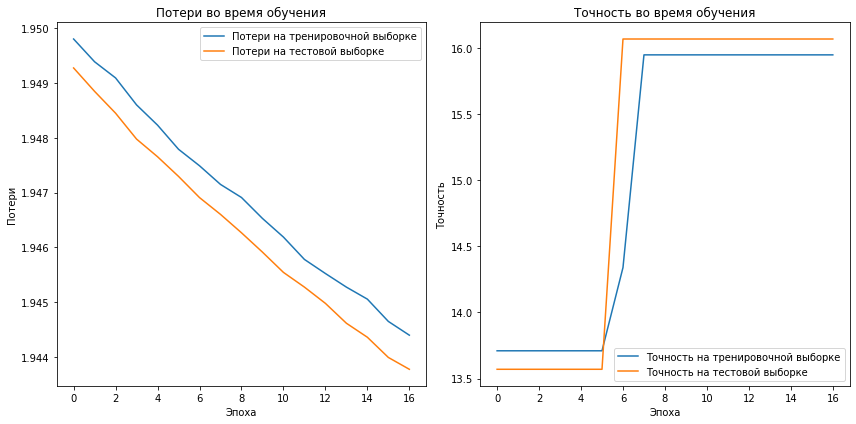

In [58]:
lstm = LSTMClassifier(num_classes = 7, model_name='xlm-roberta-base', pooling='mean', input_size=768).to(device)
optimizer = optim.AdamW(params = lstm.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(lstm, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [59]:
model_lstm_best = LSTMClassifier(num_classes = 7, model_name='xlm-roberta-base', pooling='mean', input_size=768).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LSTMClassifier_xlm-roberta-base_7_16.07_checkpoint.pth"))
model_lstm_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [60]:
evaluate_metrics(model_lstm_best, test_dataloader)

{'uar': 0.14285714285714285,
 'war': 0.16071428571428573,
 'mf1': 0.03968253968253969,
 'wf1': 0.044642857142857144}

#### LSTM + xlm-roberta-base

Тестирование 27: 100%|██████████| 9/9 [00:05<00:00,  1.63batch/s, Точность=16.8, Средняя потеря=1.94]


Ранняя остановка на эпохе 27 из-за отсутствия улучшения точности на тестовой выборке


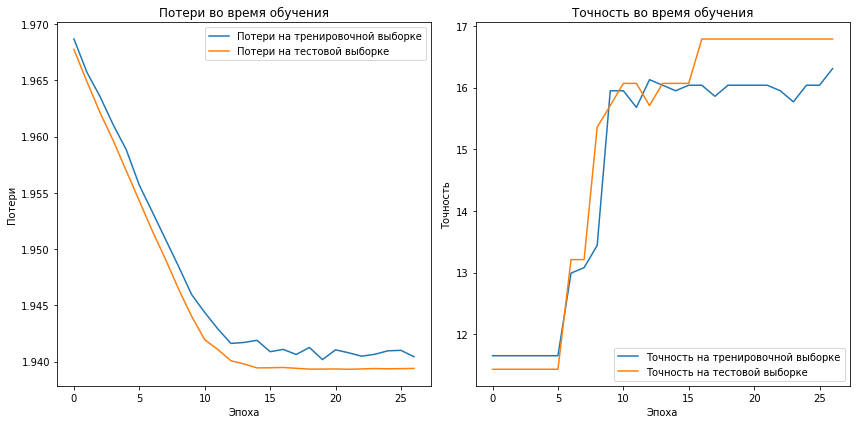

In [14]:
lstm = LSTMClassifier(num_classes = 7, model_name='xlm-roberta-base', pooling=None, input_size=768).to(device)
optimizer = optim.AdamW(params = lstm.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(lstm, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [17]:
model_lstm_best = LSTMClassifier(num_classes = 7, model_name='xlm-roberta-base', pooling=None, input_size=768).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LSTMClassifier_xlm-roberta-base_emb_17_16.79_checkpoint.pth"))
model_lstm_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [18]:
evaluate_metrics(model_lstm_best, test_dataloader)

{'uar': 0.1497835497835498,
 'war': 0.16785714285714284,
 'mf1': 0.07609653197888491,
 'wf1': 0.0846473048678931,
 'accuracy': 0.16785714285714284}

#### LSTM + canine-c with mean pooling

Тестирование 21: 100%|██████████| 9/9 [00:00<00:00, 14.19batch/s, Точность=15, Средняя потеря=1.94]


Ранняя остановка на эпохе 21 из-за отсутствия улучшения точности на тестовой выборке


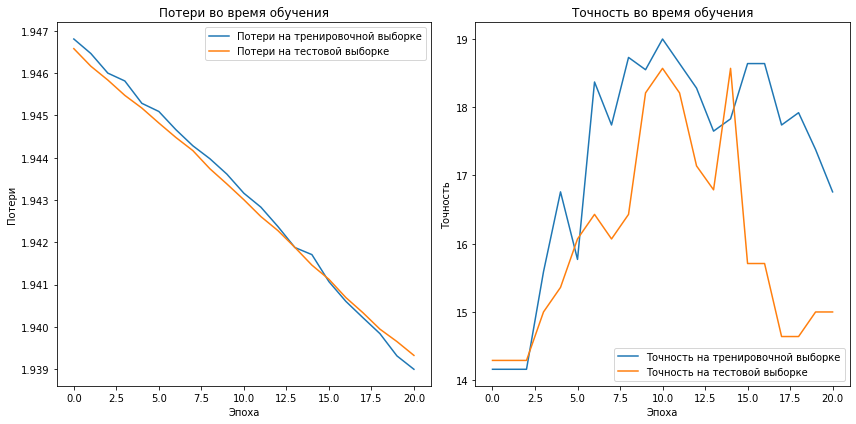

In [51]:
lstm = LSTMClassifier(num_classes = 7, model_name='canine-c', pooling='mean', input_size=768).to(device)
optimizer = optim.AdamW(params = lstm.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(lstm, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [52]:
model_lstm_best = LSTMClassifier(num_classes = 7, model_name='canine-c', pooling='mean', input_size=768).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LSTMClassifier_canine-c_11_18.57_checkpoint.pth"))
model_lstm_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [53]:
evaluate_metrics(model_lstm_best, test_dataloader)

{'uar': 0.1688311688311688,
 'war': 0.18571428571428572,
 'mf1': 0.08490292668791655,
 'wf1': 0.0933932193567082}

#### LSTM + canine-c

Тестирование 34: 100%|██████████| 9/9 [00:00<00:00, 11.08batch/s, Точность=21.8, Средняя потеря=2.02]


Ранняя остановка на эпохе 34 из-за отсутствия улучшения точности на тестовой выборке


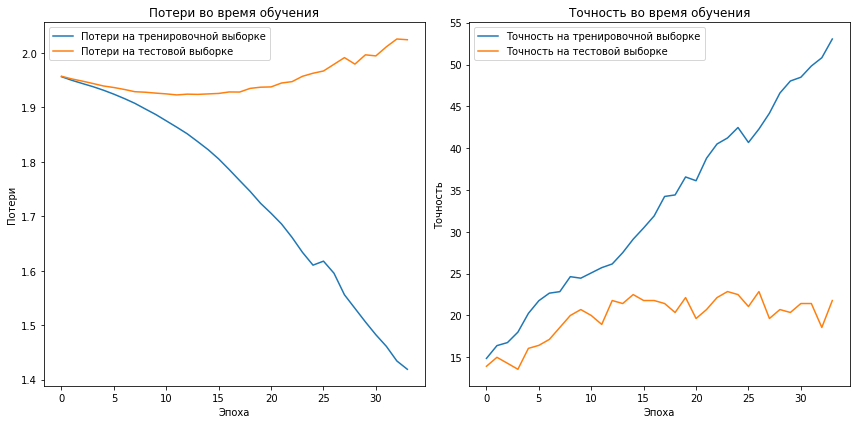

In [48]:
lstm = LSTMClassifier(num_classes = 7, model_name='canine-c', pooling=None, input_size=768).to(device)
optimizer = optim.AdamW(params = lstm.parameters(), lr = LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
trainer = ModelTrainer(lstm, train_dataloader, test_dataloader, DEVICE, 50, ROUND_LOSS, ROUND_ACC, optimizer, loss_fn, patience=10)
trainer.train(PATH_TO_MODEL)

In [49]:
model_lstm_best = LSTMClassifier(num_classes = 7, model_name='canine-c', pooling=None, input_size=768).to(device)
checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LSTMClassifier_canine-c_24_22.86_checkpoint.pth"))
model_lstm_best.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [50]:
evaluate_metrics(model_lstm_best, test_dataloader)

{'uar': 0.2166700150252782,
 'war': 0.22857142857142856,
 'mf1': 0.19828189203583818,
 'wf1': 0.2060930750899293}